In [51]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, mixture
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import h5py 

import sys
sys.path.append('../../')

from evaluation import *
np.random.seed(5)

In [2]:
from sklearn.mixture import GaussianMixture
# !pip install ard-em
from ard_em import GaussianMixtureARD

In [3]:
import pandas as pd
#! wget -o  ../../datasets/ https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
column_names = 'label, lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'.split(', ')
data = pd.read_csv('../../datasets/HIGGS.csv.gz', header=None, names=column_names)

In [4]:
X_data = data.drop('label', 1)
X_data = StandardScaler().fit_transform(X_data)

labels = data["label"]

In [52]:
from sklearn.model_selection import train_test_split
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), stratify=labels, train_size=4e-4, test_size=0.1)

In [53]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

In [54]:
X_good = X_train[np.where(y_train==0)[0]]

In [55]:
X_good.shape, X_train.shape, X_data.shape

((2068, 28), (4400, 28), (11000000, 28))

In [45]:
# gm = GaussianMixtureARD(init_components='sqrt', n_init=6, verbose=2) # EM-algorithm with automatic number of components
gm = GaussianMixture(n_components=15,n_init=6,verbose=2)

In [10]:
gm.fit(X_good)

Initialization 0
  Iteration 0	 time lapse 14.74434s	 ll change inf
  Iteration 10	 time lapse 31.04545s	 ll change 0.06649
  Iteration 20	 time lapse 30.07173s	 ll change 0.00821
  Iteration 30	 time lapse 30.48997s	 ll change 0.00293
  Iteration 40	 time lapse 30.54890s	 ll change 0.00366
Initialization converged: True	 time lapse 157.78134s	 ll -20.66842
Initialization 1
  Iteration 0	 time lapse 23.68269s	 ll change inf
  Iteration 10	 time lapse 30.13651s	 ll change 0.07456
  Iteration 20	 time lapse 30.34606s	 ll change 0.00777
  Iteration 30	 time lapse 30.34698s	 ll change 0.01190
  Iteration 40	 time lapse 30.10193s	 ll change 0.00228
  Iteration 50	 time lapse 30.01702s	 ll change 0.00512
Initialization converged: True	 time lapse 192.84814s	 ll -20.05734
Initialization 2
  Iteration 0	 time lapse 13.60592s	 ll change inf
  Iteration 10	 time lapse 30.43971s	 ll change 0.07963
  Iteration 20	 time lapse 30.89158s	 ll change 0.00268
Initialization converged: True	 time lapse 8

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=15, n_init=6, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=2,
        verbose_interval=10, warm_start=False, weights_init=None)

In [11]:
from scipy.stats import multivariate_normal

In [12]:
n_samples = X_good.shape[0]

In [13]:
gen = np.array(multivariate_normal.rvs(mean=gm.means_[0], cov=gm.covariances_[0], size=int(gm.weights_[0]*n_samples)))
for d in range(1,gm.n_components):
    gen=np.vstack((gen,multivariate_normal.rvs(mean=gm.means_[d], cov=gm.covariances_[d], size=int(gm.weights_[d]*n_samples))))
np.random.shuffle(gen)
gen = np.array(gen)

In [14]:
probabilities = np.empty((gm.n_components, gen.shape[0]))

In [15]:
for d in range(gm.n_components):
    probabilities[d] = multivariate_normal.pdf(gen, mean=gm.means_[d], 
                                                    cov=gm.covariances_[d], allow_singular=True)

In [16]:
gen.shape

(517079, 28)

In [17]:
maxprob = np.max(probabilities, axis = 0)
gen_w = 1./(maxprob+1e-2)

In [18]:
#indices = gen_w.argsort()[-50:][::-1] #_toobig
#indices_toosmall = gen_w.argsort()[:200][::-1]

#indices = np.concatenate((indices_toosmall,indices_toobig))

In [19]:
#gen_w = np.delete(gen_w, indices)
#gen = np.delete(gen, indices, axis = 0)

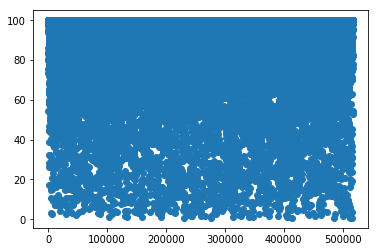

In [20]:
plt.scatter(np.arange(len(gen_w)), gen_w)
plt.show()

In [21]:
weights = np.ones((n_samples,1)) #X_train.shape[0]

In [22]:
gen_w_normed = gen_w/np.sum(gen_w)*np.sum(weights)

In [23]:
gen_w_normed.sum(), np.sum(weights)

(517088.00000000006, 517088.0)

In [24]:
gen_w_normed

array([1.00917948, 1.00918413, 1.00918402, ..., 1.00702343, 1.00918088,
       1.00918413])

In [25]:
y1 = np.zeros((n_samples,1))
y2 = np.ones((gen.shape[0],1))

In [26]:
X_mix = np.vstack((X_good, gen)) #X_good

y_mix = np.vstack((y1, y2)) #y_train

weights_mix = np.vstack((weights.reshape(-1,1), gen_w_normed.reshape(-1,1))).reshape(-1)

In [27]:
weights_mix.shape

(1034167,)

In [28]:
import tensorflow as tf

s = tf.InteractiveSession()

import keras
from keras.models import Sequential
from keras import layers as L

Using TensorFlow backend.


In [29]:
net = Sequential()
net.add(L.Dense(64, input_shape=(X_data.shape[1],), activation = 'relu'))
#net.add(L.BatchNormalization())
#net.add(L.Dense(32, activation='relu'))
net.add(L.BatchNormalization())
net.add(L.Dropout(0.2))
net.add(L.Dense(1, activation='sigmoid'))

adam = keras.optimizers.Adam(lr=0.001)
net.compile(optimizer=adam, loss='binary_crossentropy')

In [32]:
history = net.fit(X_mix, y_mix, batch_size=256, epochs=100, validation_split = 0.1, verbose=1, shuffle=True, sample_weight=weights_mix)

Train on 930750 samples, validate on 103417 samples
Epoch 1/100
930750/930750 [==============================] - 10s 10us/step - loss: 0.4478 - val_loss: 0.4344
Epoch 2/100
930750/930750 [==============================] - 10s 10us/step - loss: 0.4465 - val_loss: 0.4378
Epoch 3/100
930750/930750 [==============================] - 10s 10us/step - loss: 0.4446 - val_loss: 0.4288
Epoch 4/100
930750/930750 [==============================] - 10s 10us/step - loss: 0.4315 - val_loss: 0.3842
Epoch 5/100
930750/930750 [==============================] - 10s 11us/step - loss: 0.4259 - val_loss: 0.4153
Epoch 6/100
930750/930750 [==============================] - 10s 11us/step - loss: 0.4249 - val_loss: 0.3990
Epoch 7/100
930750/930750 [==============================] - 10s 10us/step - loss: 0.4213 - val_loss: 0.3834
Epoch 8/100
930750/930750 [==============================] - 10s 10us/step - loss: 0.4198 - val_loss: 0.3574
Epoch 9/100
930750/930750 [==============================] - 9s 10us/step - 

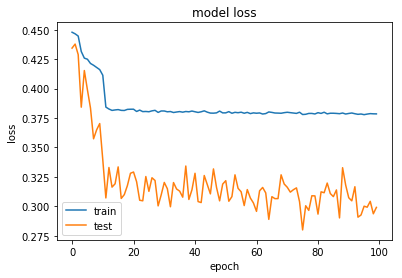

In [33]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

1100000/1100000 [==============================] - 18s 17us/step

('f1_score ', 0.10877948001152533)
confusion_matrix 
[[483012  34076]
 [547424  35488]]


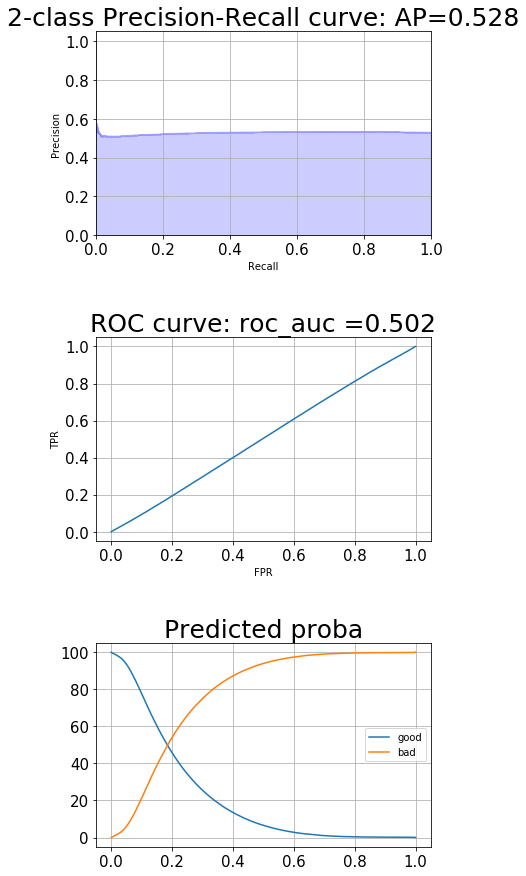

In [34]:
y_pred = net.predict(X_test, verbose=1)
print ('')
perfomance(y_test, y_pred)

## Classic methods

In [56]:
X_mix = np.vstack([X_train[y_train == 0], X_train[y_train == 1][:20]])
y_mix = np.concatenate([np.zeros_like(y_train[y_train == 0]), np.zeros_like(y_train[y_train == 1][:20])])

In [57]:
import xgboost as xgb
import sys
sys.path.append('../../')
from evaluation import get_anomaly_metrics
clf = xgb.XGBClassifier()
clf.fit(X_mix, y_mix)
y_pred = clf.predict(X_test)
print(get_anomaly_metrics(y_test, y_pred))    

/home/aryzhikov/.conda/envs/lasagne2.7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'Precision@0.9': 0.52992, 'Precision@0.8': 0.52992, 'PR_AUC': 0.52992, 'Precision@0.95': 0.52992, 'P@10': 0.0, 'Precision@0.99': 0.52992, 'ROC_AUC': 0.5}


In [58]:
y_test_rescale = np.where(y_test == 0, np.ones((y_test.shape)), -np.ones((y_test.shape)))

In [59]:
from sklearn import svm
from sklearn.ensemble import IsolationForest


classifiers_classic = {
    "One-Class SVM": svm.OneClassSVM(nu=0.03,
                                     kernel="rbf", gamma=1e-5),
    "Isolation Forest": IsolationForest(n_estimators=500,
                                        contamination=0.01,
                                        random_state=10)}


for i, (clf_name, clf) in enumerate(classifiers_classic.items()):
        print(clf_name)
        clf.fit(X_good)
        #scores_pred = clf.decision_function(X_test)
        y_pred = clf.predict(X_test)
        
        print(get_anomaly_metrics(y_test, y_pred))

Isolation Forest
{'Precision@0.9': 0.52992, 'Precision@0.8': 0.52992, 'PR_AUC': 0.5307531165686088, 'Precision@0.95': 0.52992, 'P@10': 1.0, 'Precision@0.99': 0.52992, 'ROC_AUC': 0.5016695729221882}
One-Class SVM
{'Precision@0.9': 0.52992, 'Precision@0.8': 0.52992, 'PR_AUC': 0.5318750886441918, 'Precision@0.95': 0.52992, 'P@10': 0.5, 'Precision@0.99': 0.52992, 'ROC_AUC': 0.5039093890950975}


In [50]:
classifiers_classic.items()

[('Isolation Forest',
  IsolationForest(bootstrap=False, contamination=0.01, max_features=1.0,
          max_samples='auto', n_estimators=500, n_jobs=1, random_state=10,
          verbose=0)),
 ('One-Class SVM',
  OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=1e-05, kernel='rbf',
        max_iter=-1, nu=0.03, random_state=None, shrinking=True, tol=0.001,
        verbose=False))]